In [1]:
import copy
import scanpy as sc
import scover as scov
import numpy as np
import pickle
import pandas as pd
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
from pytorch_lightning.utilities.warnings import LightningDeprecationWarning
warnings.filterwarnings("ignore", category=LightningDeprecationWarning) 

# Running scover

In this example, I am using the bone marrow dataset from Tabula Muris (see parts 1 and 2). As this is a mock example, I am only running the network for a few epochs with a limited hyperparameter sweep. As such, the results are not representative, but this notebook is designed to show how to go from input data to analysing the output data.

In [2]:
ad = sc.read("data/Marrow_pooled.h5ad")
# Check if sequence information is there:
ad.var

,symbol,promoter_seq
0610005C13Rik,0610005C13Rik,ttggtcatctgaatctggaggtctgcagcctgagagaaagaaataa...
0610007P14Rik,0610007P14Rik,gggaccacgctctgcttcacctccctcctccttccccagcccgaat...
0610009B22Rik,0610009B22Rik,gaagtcaatgatttttagccaaagtagcttcgaaatgtctgtttaa...
0610009L18Rik,0610009L18Rik,gaggagtgcagtccccaccccgggcggcgtaaccgtcggctaccgg...
0610009O20Rik,0610009O20Rik,attagccagatatctctttggtggttaagttacatcgcaaaaggtt...
...,...,...
Zyx,Zyx,cttgtccccggggcaatactattgcaggcgggtctagggcaaagcg...
Zzef1,Zzef1,ggctcagcaccacaccaagcccgcatatcctcagcatctatacagc...
Zzz3,Zzz3,agatggcaggtgtgatagtcagtataactataattggtattcttta...
a,a,ccgccctcagcctgctgctcctccctcgtgtcctcccgcccgtcag...


Let's check the data:

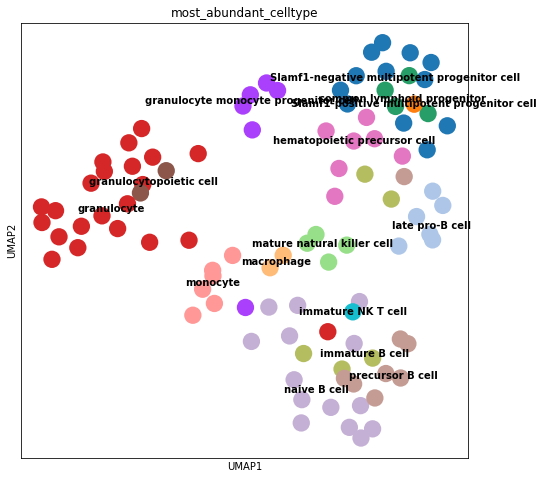

In [3]:
mpl.rcParams["figure.figsize"] = (8,8)
sc.pl.umap(ad, color='most_abundant_celltype', legend_loc='on data')

## Filter genes based on expression:

(100, 16249)

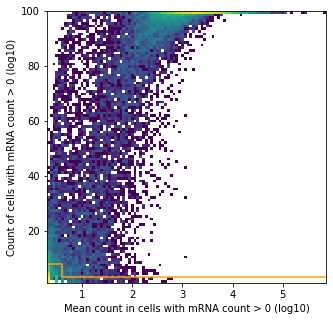

In [4]:
mpl.rcParams["figure.figsize"] = (5, 5)

# To avoid dividing by 0
sc.pp.filter_genes(ad, min_cells=1)

# calculate the mean of each gene across non-zero cells
n_cells = (ad.X > 0).sum(0)
nonz_mean = ad.X.sum(0) / n_cells

plt.hist2d(nonz_mean, n_cells, bins=100, norm=mpl.colors.LogNorm())

nonz_mean_cutoff = np.log10(4)  # cut off for expression in non-zero cells
cell_count_cutoff = ad.shape[
    0] * 0.03  # cut off percentage for cells with higher expression
cell_count_cutoff2 = ad.shape[
    0] * 0.08  # cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff,
           cell_count_cutoff,
           cell_count_cutoff2,
           color='orange')
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, max(nonz_mean), color='orange')
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='orange')
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)')
plt.ylabel('Count of cells with mRNA count > 0 (log10)')

# Everything below the orange line is excluded
ad[:, ((np.array(nonz_mean > nonz_mean_cutoff)
        | np.array(n_cells > cell_count_cutoff2))
       & np.array(n_cells > cell_count_cutoff))].shape

Apply the filter:

In [5]:
ad = ad[:, ((np.array(nonz_mean > nonz_mean_cutoff)
             | np.array(n_cells > cell_count_cutoff2))
            & np.array(n_cells > cell_count_cutoff))]

## Convert sequences to sequence tensor

In [6]:
X_seqs = scov.seq_list_to_conv(list(ad.var['promoter_seq']), expand=True)
X_seqs.shape

(16249, 1, 1000, 4)

## Get count data from the AnnData object

I transpose the data matrix because I want genes by cells, not cells by genes. (The batches are along the gene axis)

In [7]:
X_data = ad.X.T  
X_data.shape

(16249, 100)

# Setting up the hyperparameter search with Ray Tune + Pytorch Lightning

## Get train-val-test splits

In [8]:
k_outer = 10
idx_sets = scov.get_splits(ind_list = list(range(X_data.shape[0])),
                           n_splits = k_outer)
len(idx_sets['test'])

10

## Run the training loop

For this, you will require a GPU, otherwise this might take a long time. (It is possible if you set `num_gpus` to `0`).

One way to keep track of the runs while they are running is to open a terminal after the runs have started and run `tensorboard --logdir $logdir` where `$logdir` is `{exp_name}_tune` (so in this case the full command would be `tensorboard --logdir Marrow_pool80_tune`. This opens a tensorboard session with live-updating plots for the different runs:

|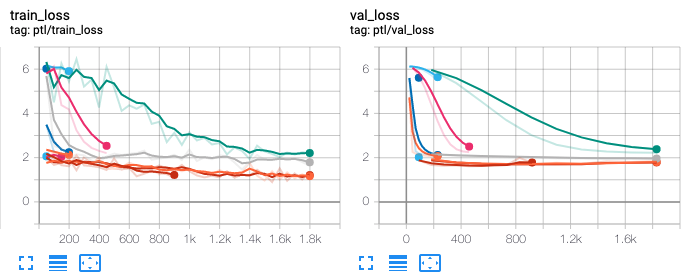|
|:-----:|
|Example outputs in tensorboard|

Specify parameters and output directories below. This is a toy example, usually `trials_per_outer` is set to `100`, and `epochs_per_hyperparam_opt` is set to `40`.

In [9]:
exp_name = "Marrow_pool80"
trials_per_outer = 2
epochs_per_hyperparam_opt = 10
final_epochs = 10
num_gpus = 1

In [10]:
pickle.dump(idx_sets, open(f"models/{exp_name}_backup_idx_sets.p", "wb"))

all_analyses = []
for curr_outer in range(k_outer):
    curr_train_idx = idx_sets['inner_train'][curr_outer]
    curr_val_idx = idx_sets['val'][curr_outer]
    curr_test_idx = idx_sets['test'][curr_outer]
    train_data = scov.SeqDataset(X_seqs[curr_train_idx],
                                 X_data[curr_train_idx],
                                 dtype="float")
    val_data = scov.SeqDataset(X_seqs[curr_val_idx],
                               X_data[curr_val_idx],
                               dtype="float")
    curr_analysis = scov.tune_scover_asha_hyperopt(
        train_data,
        val_data,
        num_samples=trials_per_outer,
        num_epochs=epochs_per_hyperparam_opt,
        local_dir=f"./{exp_name}_tune",
        prefix=f"{exp_name}_" + str(curr_outer),
        gpus_per_trial=1 if num_gpus > 0 else 0)
    all_analyses.append(curr_analysis)
    best_config = curr_analysis.get_best_config(metric='loss', mode='min')
    train_loader = DataLoader(train_data,
                              batch_size=best_config["batch_size"],
                              num_workers=2,
                              shuffle=True)
    val_loader = DataLoader(val_data,
                            batch_size=best_config["batch_size"],
                            num_workers=2,
                            shuffle=False)
    seq_length = train_loader.dataset[0][0].shape[1]
    output_size = train_loader.dataset[0][1].shape[0]
    sn = scov.SeqNet(seq_length=seq_length,
                     output_size=output_size,
                     learning_rate=best_config["learning_rate"],
                     motif_length=12,
                     num_motifs=600,
                     sigma_motifs=best_config["sigma_motifs"],
                     sigma_net=best_config["sigma_net"])
    early_stop_callback = EarlyStopping(monitor='ptl/val_loss',
                                        patience=4,
                                        verbose=False,
                                        mode='min')
    trainer = pl.Trainer(max_epochs=final_epochs,
                         gpus=1 if num_gpus > 0 else 0,
                         callbacks=[early_stop_callback])
    trainer.fit(sn, train_loader, val_loader)
    state_dict_path = f"models/{exp_name}_trained_outer_" + str(
        curr_outer) + ".p"
    torch.save(sn.state_dict(), state_dict_path)

all_best_configs = [
    x.get_best_config(metric="loss", mode="min") for x in all_analyses
]
pickle.dump(all_best_configs,
            open(f"models/{exp_name}_backup_all_best_configs.p", "wb"))

Trial name,status,loc,batch_size,learning_rate,sigma_motifs,sigma_net,loss,training_iteration
train_scover_bs_5c0caae8,TERMINATED,10.160.0.18:46192,64,0.0007449,8.06819e-07,0.000155949,1.72544,10
train_scover_bs_60a17912,TERMINATED,10.160.0.18:49372,256,0.000192133,1.03809e-05,0.00036406,4.46987,1


2022-04-28 23:42:30,680	INFO tune.py:701 -- Total run time: 54.92 seconds (54.78 seconds for the tuning loop).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type      | Params
-------------------------------------
0 | conv_1 | Conv2d    | 28.8 K
1 | pool_1 | MaxPool2d | 0     
2 | fc     | Linear    | 60.1 K
-------------------------------------
88.9 K    Trainable params
0         Non-trainable params
88.9 K    Total params
0.356     Total estimated model params size (MB)


Best hyperparameters found were:  {'batch_size': 64, 'learning_rate': 0.0007449001101296834, 'sigma_motifs': 8.068189802601567e-07, 'sigma_net': 0.00015594886317375233}


Sanity Checking: 0it [00:00, ?it/s]

/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Calculate PWMs of motifs

The PWMs are representations of what subsequences are activated by each of the convolutional filters in the neural network.

In [11]:
all_pfm_dicts = {}
all_ppm_dicts = {}
for curr_outer in range(k_outer):
    curr_train_idx = idx_sets['inner_train'][curr_outer]
    curr_test_idx = idx_sets['test'][curr_outer]
    curr_val_idx = idx_sets['val'][curr_outer]
    
    train_data = scov.SeqDataset(X_seqs[curr_train_idx], X_data[curr_train_idx], dtype="float")
    train_loader = DataLoader(train_data, batch_size=128, num_workers=0, shuffle=False)
    
    test_data = scov.SeqDataset(X_seqs[curr_test_idx], X_data[curr_test_idx], dtype="float")
    test_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)
    
    val_data = scov.SeqDataset(X_seqs[curr_val_idx], X_data[curr_val_idx], dtype="float")
    val_loader = DataLoader(val_data, batch_size=128, num_workers=0, shuffle=False)

    sn = scov.SeqNet(seq_length=seq_length, 
                     output_size=output_size, 
                     learning_rate=all_best_configs[curr_outer]["learning_rate"],
                     motif_length=12,
                     num_motifs=600,
                     sigma_motifs=all_best_configs[curr_outer]["sigma_motifs"],
                     sigma_net=all_best_configs[curr_outer]["sigma_net"])
    state_dict_path = f"models/{exp_name}_trained_outer_" + str(
        curr_outer) + ".p"
    sn.load_state_dict(torch.load(state_dict_path))
    
    sn = sn.to(torch.device('cuda'))
    sn.eval()
    
    curr_pfm_dict, curr_ppm_dict = scov.align_conv_filters(sn, train_loader)
    
    all_pfm_dicts[curr_outer] = curr_pfm_dict
    all_ppm_dicts[curr_outer] = curr_ppm_dict

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

## Save MEME file with motifs

In [12]:
all_motifs_ppm_dict = {}
for i,can_nr in enumerate(range(k_outer)):
    for key in all_ppm_dicts[i].keys():
        all_motifs_ppm_dict[str(can_nr)+"_"+key] = all_ppm_dicts[i][key]
    
# Save big MEME file with all motifs
all_meme_output_path = f"output/{exp_name}_all_MEME_motifs.txt"
scov.save_meme(all_motifs_ppm_dict, all_meme_output_path)    

wrote meme list


In [13]:
all_motifs_pfm_dict = {}
for i,can_nr in enumerate(range(k_outer)):
    for key in all_pfm_dicts[i].keys():
        all_motifs_pfm_dict[str(can_nr)+"_"+key] = all_pfm_dicts[i][key]
pickle.dump(all_motifs_pfm_dict, open(f"output/{exp_name}_all_motifs_pfm_dict.p", "wb"))

## Calculate influence scores

This is how to calculate the influence scores for individual convolutional filters for setting their weights to 0 and assessing the difference in the output (a bit like a saturation mutagenesis experiment, but at the level of feature extraction rather than the input). Here the influence scores are abbreviated LOO for leave-one-out.

In [17]:
all_loo_scores = np.zeros((600 * k_outer, output_size))
for curr_outer in range(k_outer):
    curr_train_idx = idx_sets['inner_train'][curr_outer]
    curr_test_idx = idx_sets['test'][curr_outer]
    curr_val_idx = idx_sets['val'][curr_outer]
    
    train_data = scov.SeqDataset(X_seqs[curr_train_idx], X_data[curr_train_idx], dtype="float")
    train_loader = DataLoader(train_data, batch_size=128, num_workers=0, shuffle=False)
    
    test_data = scov.SeqDataset(X_seqs[curr_test_idx], X_data[curr_test_idx], dtype="float")
    test_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)
    
    val_data = scov.SeqDataset(X_seqs[curr_val_idx], X_data[curr_val_idx], dtype="float")
    val_loader = DataLoader(val_data, batch_size=128, num_workers=0, shuffle=False)

    sn = scov.SeqNet(seq_length=seq_length, 
                output_size=output_size, 
                learning_rate=all_best_configs[curr_outer]["learning_rate"],
                motif_length=12,
                num_motifs=600,
                sigma_motifs=all_best_configs[curr_outer]["sigma_motifs"],
                sigma_net=all_best_configs[curr_outer]["sigma_net"])

    # Load current candidate model
    state_dict_path = f"models/{exp_name}_trained_outer_" + str(
        curr_outer) + ".p"
    sn.load_state_dict(torch.load(state_dict_path))
    
    sn = sn.to(torch.device('cuda'))
    sn.eval()

    data_loader = val_loader
    device = torch.device("cuda")

    n_seq = len(data_loader.dataset)
    seq_len = data_loader.dataset[0][0].shape[1]
    d = sn.conv_1.weight.shape[0]
    m = sn.conv_1.weight.shape[2]
    
    fc_cpu = copy.deepcopy(sn.fc).cpu()

    # Get activations
    activations = torch.FloatTensor(size=(n_seq, d, 1, 1)) # assumes padding=0, strides=1
    curr_i = 0
    for idx, (seqs, vals) in enumerate(tqdm(data_loader)):
        curr_batch_size = len(seqs)
        seqs = seqs.to(device)
        with torch.no_grad():
            activations[curr_i:curr_i+curr_batch_size,:,:,:] = sn.pool_1(F.relu(sn.conv_1(seqs))).detach().cpu()
        curr_i += curr_batch_size
    
    # Get normal prediction
    normal_prediction = torch.FloatTensor(size=(n_seq, sn.output_size))
    curr_i = 0
    for idx, (seqs, vals) in enumerate(tqdm(data_loader)):
        curr_batch_size = len(seqs)
        seqs = seqs.to(device)
        with torch.no_grad():
            normal_prediction[curr_i:curr_i+curr_batch_size,:] = sn(seqs)
        curr_i += curr_batch_size
    normal_prediction = normal_prediction.numpy()
    
    # Using the model activations, predict the output when iteratively setting a motif to zeroes only. 
    zeroes_fill = torch.zeros((activations.shape[0], 1, 1)).cpu()
    left_out_curr_model = np.zeros((sn.num_motifs, sn.output_size))
    for i in tqdm(range(d)):
        curr_set_0 = torch.clone(activations)
        curr_set_0[:,i,:,:] = torch.clone(zeroes_fill)
        curr_set_0 = curr_set_0.view(-1, d)
        all_loo_scores[(sn.num_motifs * curr_outer) + i,:] = np.mean(normal_prediction - fc_cpu(curr_set_0.cpu()).detach().numpy(), axis=0)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Save:

In [18]:
pickle.dump(all_loo_scores, open(f"output/{exp_name}_all_loo_scores_1.p", "wb"))

In [20]:
num_motifs = int(all_loo_scores.shape[0] / k_outer)
all_motif_names = [str(x) + "_" + str(y) for x in [x for x in range(k_outer)] for y in [y for y in range(num_motifs)]]
all_loo_scores_df = pd.DataFrame(all_loo_scores, 
                                 index = all_motif_names, 
                                 columns = ad.obs_names)
all_loo_scores_df

,pseudobulk_0,pseudobulk_1,pseudobulk_2,pseudobulk_3,pseudobulk_4,pseudobulk_5,pseudobulk_6,pseudobulk_7,pseudobulk_8,pseudobulk_9,...,pseudobulk_90,pseudobulk_91,pseudobulk_92,pseudobulk_93,pseudobulk_94,pseudobulk_95,pseudobulk_96,pseudobulk_97,pseudobulk_98,pseudobulk_99
0_0,5.939374e-03,4.851643e-03,6.810288e-03,5.117766e-03,6.277359e-03,5.377144e-03,4.894334e-03,5.505250e-03,6.305889e-03,3.919344e-03,...,6.678705e-03,7.080489e-03,6.792180e-03,6.927168e-03,6.059499e-03,6.051358e-03,5.796537e-03,6.408792e-03,5.469267e-03,5.465270e-03
0_1,6.737370e-03,5.522095e-03,7.841107e-03,5.843908e-03,7.242518e-03,6.175150e-03,5.562068e-03,6.292345e-03,7.231537e-03,4.303086e-03,...,7.666002e-03,8.145497e-03,7.807557e-03,7.948817e-03,6.907594e-03,6.855483e-03,6.675574e-03,7.366747e-03,6.269253e-03,6.263732e-03
0_2,-7.075122e-08,-6.555492e-08,-1.218584e-08,-5.177963e-08,-7.107727e-08,-3.394917e-08,-6.973234e-08,-3.686318e-08,8.395594e-09,-1.711723e-09,...,-6.928403e-09,1.699497e-08,-2.693926e-08,-1.866593e-08,4.650181e-08,-1.365303e-08,-3.472353e-08,-7.727207e-08,-2.759135e-08,-4.320063e-08
0_3,-7.075122e-08,-6.555492e-08,-1.218584e-08,-5.177963e-08,-7.107727e-08,-3.394917e-08,-6.973234e-08,-3.686318e-08,8.395594e-09,-1.711723e-09,...,-6.928403e-09,1.699497e-08,-2.693926e-08,-1.866593e-08,4.650181e-08,-1.365303e-08,-3.472353e-08,-7.727207e-08,-2.759135e-08,-4.320063e-08
0_4,6.312588e-03,5.222913e-03,7.240273e-03,5.513359e-03,6.566191e-03,5.653977e-03,5.288676e-03,5.966668e-03,6.655256e-03,4.288583e-03,...,7.008803e-03,7.436891e-03,7.227753e-03,7.238598e-03,6.512881e-03,6.475723e-03,6.279639e-03,6.758204e-03,5.758215e-03,5.810552e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_595,5.891181e-08,-7.030291e-10,-2.037766e-09,-2.017388e-09,2.971062e-08,-2.657246e-08,5.216680e-09,-2.137616e-08,-8.151063e-09,-3.362313e-08,...,-4.230402e-08,5.127018e-08,1.609835e-09,5.155547e-09,-3.512089e-08,2.385205e-08,1.721912e-09,-1.964406e-08,-1.687270e-08,3.874811e-08
9_596,5.891181e-08,-7.030291e-10,-2.037766e-09,-2.017388e-09,2.971062e-08,-2.657246e-08,5.216680e-09,-2.137616e-08,-8.151063e-09,-3.362313e-08,...,-4.230402e-08,5.127018e-08,1.609835e-09,5.155547e-09,-3.512089e-08,2.385205e-08,1.721912e-09,-1.964406e-08,-1.687270e-08,3.874811e-08
9_597,5.891181e-08,-7.030291e-10,-2.037766e-09,-2.017388e-09,2.971062e-08,-2.657246e-08,5.216680e-09,-2.137616e-08,-8.151063e-09,-3.362313e-08,...,-4.230402e-08,5.127018e-08,1.609835e-09,5.155547e-09,-3.512089e-08,2.385205e-08,1.721912e-09,-1.964406e-08,-1.687270e-08,3.874811e-08
9_598,5.569724e-03,5.443512e-03,6.803853e-03,4.329754e-03,7.129648e-03,6.025414e-03,4.785920e-03,4.968850e-03,6.066344e-03,5.055184e-03,...,7.123645e-03,8.155729e-03,6.636171e-03,7.477434e-03,6.009257e-03,5.507187e-03,5.079135e-03,7.909604e-03,5.384093e-03,7.310254e-03


In [24]:
all_loo_scores_df.to_csv(f"output/{exp_name}_all_loo_scores_df.csv")

## Load in motif cluster database

I compiled the motif cluster resource from [this source](https://www.vierstra.org/resources/motif_clustering).

In [27]:
jvdf = pd.read_csv("../resources/motif_annotations_with_possible_gene.csv", index_col=0)
jvdf

,Cluster_ID,Motif,Database,Consensus,Relative_orientation,Width,Left_offset,Right_offset,Cluster_name,Cluster_type,mouse_gene,human_gene
0,1,LHX6_homeodomain_3,Taipale_Cell_2013,TGATTGCAATCA,+,12,0,0,HD/1:homeodomain,homeodomain,Lhx6,LHX6
1,1,Lhx8.mouse_homeodomain_3,Taipale_Cell_2013,TGATTGCAATTA,-,12,0,0,HD/1:homeodomain,homeodomain,Lhx8,LHX8
2,2,LHX2_MOUSE.H11MO.0.A,HOCOMOCO_v11,ACTAATTAAC,-,10,7,9,HD/2:homeodomain,homeodomain,Lhx2,LHX2
3,2,LHX2_HUMAN.H11MO.0.A,HOCOMOCO_v11,AACTAATTAAAA,-,12,6,8,HD/2:homeodomain,homeodomain,Lhx2,LHX2
4,2,LHX3_MOUSE.H11MO.0.C,HOCOMOCO_v11,TTAATTAGC,-,9,8,9,HD/2:homeodomain,homeodomain,Lhx3,LHX3
...,...,...,...,...,...,...,...,...,...,...,...,...
2169,284,Ahr+Arnt_MA0006.1,Jaspar2018,TGCGTG,+,6,2,1,AHR:bHLH,bHLH,Ahr,AHR
2170,285,KLF8_HUMAN.H11MO.0.C,HOCOMOCO_v11,CAGGGGGTG,+,9,0,0,KLF/SP/3:C2H2,C2H2,Klf8,KLF8
2171,285,KLF8_MOUSE.H11MO.0.C,HOCOMOCO_v11,CAGGGGGTG,+,9,0,0,KLF/SP/3:C2H2,C2H2,Klf8,KLF8
2172,286,ZSCAN4_MA1155.1,Jaspar2018,TGCACACACTGAAAA,+,15,0,0,ZSCAN4:C2H2,C2H2,Zscan4,ZSCAN4


In [37]:
subcluster_gene_sets = {}
for cluster in jvdf["Cluster_name"].unique():
    subcluster_gene_sets[cluster] = list(jvdf[jvdf["Cluster_name"] == cluster]["mouse_gene"].unique())
cluster_gene_sets = {}
for cluster in jvdf["Cluster_type"].unique():
    cluster_gene_sets[cluster] = list(jvdf[jvdf["Cluster_type"] == cluster]["mouse_gene"].unique())

## Align motifs database using Tomtom

For the next bit, it is necessary to install Tomtom from the MEME suite using e.g. `conda install -c bioconda meme`.

In [36]:
!tomtom -o output/tomtom_$exp_name -thresh 0.05 \
  'output/'$exp_name'_all_MEME_motifs.txt' ../resources/Mus_musculus.meme

Writing results to output directory 'output/tomtom_Marrow_pool80'.
Processing query 1 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 2 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 3 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 4 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.991898
#   Estimated pi_0=0.993219
Processing query 5 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997326
#   Estimated pi_0=0.997326
Processing query 6 out o

#   Estimated pi_0=0.980558
Processing query 46 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 47 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998726
#   Estimated pi_0=0.998726
Processing query 48 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 49 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996847
#   Estimated pi_0=0.998026
Processing query 50 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 51 out of 3134 
# Computing q-values.
#   Estimat

#   Estimated pi_0=1
Processing query 91 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 92 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 93 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996627
#   Estimated pi_0=0.996627
Processing query 94 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996736
#   Estimated pi_0=0.998026
Processing query 95 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.989777
#   Estimated pi_0=0.992427
Processing query 96 out of 3134 
# Computing q-values.
#   Estima

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 137 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998143
#   Estimated pi_0=1
Processing query 138 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998726
#   Estimated pi_0=0.998726
Processing query 139 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 140 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 141 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimatin

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.991898
#   Estimated pi_0=0.992427
Processing query 182 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 183 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.99955
#   Estimated pi_0=1
Processing query 184 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.984828
#   Estimated pi_0=0.986185
Processing query 185 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.990243
#   Estimated pi_0=0.990328
Processing query 186 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Es

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.99744
#   Estimated pi_0=0.998026
Processing query 227 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 228 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998143
#   Estimated pi_0=1
Processing query 229 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 230 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.991898
#   Estimated pi_0=0.992427
Processing query 231 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 272 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 273 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 274 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998726
#   Estimated pi_0=0.998726
Processing query 275 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.992516
#   Estimated pi_0=0.993827
Processing query 276 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Es

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997326
#   Estimated pi_0=0.997326
Processing query 317 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998143
#   Estimated pi_0=1
Processing query 318 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 319 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 320 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 321 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   E

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 363 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 364 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 365 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 366 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 367 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 409 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 410 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 411 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 412 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 413 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 455 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 456 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.983329
#   Estimated pi_0=0.983329
Processing query 457 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996627
#   Estimated pi_0=0.996627
Processing query 458 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 459 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.994626
#   Estimated pi_0=0.995927
Processing query 500 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 501 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 502 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 503 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 504 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
#

#   Estimated pi_0=1
Processing query 545 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 546 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 547 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 548 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 549 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 550 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.986185
#   Estimated pi_0=0.987528
Processing query 591 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 592 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.984446
#   Estimated pi_0=0.987747
Processing query 593 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997326
#   Estimated pi_0=0.997326
Processing query 594 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998143
#   Estimated pi_0=0.999426
Processing query 595 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 637 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 638 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 639 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 640 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 641 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
#

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 682 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 683 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 684 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 685 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 686 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 727 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998026
#   Estimated pi_0=0.998026
Processing query 728 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 729 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 730 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 731 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
#

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.987592
#   Estimated pi_0=0.988228
Processing query 772 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.991812
#   Estimated pi_0=0.991812
Processing query 773 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 774 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996595
#   Estimated pi_0=1
Processing query 775 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.991191
#   Estimated pi_0=0.992427
Processing query 776 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   E

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.995329
#   Estimated pi_0=0.995927
Processing query 817 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.990328
#   Estimated pi_0=0.990328
Processing query 818 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 819 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 820 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.988928
#   Estimated pi_0=0.988928
Processing query 821 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Es

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 862 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 863 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 864 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 865 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 866 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.986828
#   Estimated pi_0=0.986828
Processing query 908 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 909 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97703
#   Estimated pi_0=0.97703
Processing query 910 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999929
#   Estimated pi_0=1
Processing query 911 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.990328
#   Estimated pi_0=0.990328
Processing query 912 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Est

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 953 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.992516
#   Estimated pi_0=0.992516
Processing query 954 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993923
#   Estimated pi_0=0.995227
Processing query 955 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.985482
#   Estimated pi_0=0.985482
Processing query 956 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998026
#   Estimated pi_0=0.998026
Processing query 957 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed 

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.982707
#   Estimated pi_0=0.983329
Processing query 998 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 999 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 1000 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.981261
#   Estimated pi_0=0.983329
Processing query 1001 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 1002 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimat

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1044 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1045 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999675
#   Estimated pi_0=1
Processing query 1046 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996468
#   Estimated pi_0=0.999426
Processing query 1047 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 1048 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating p

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.992516
#   Estimated pi_0=0.994527
Processing query 1089 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 1090 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.995927
#   Estimated pi_0=0.995927
Processing query 1091 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1092 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1093 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.992605
#   Estimated pi_0=0.993923
Processing query 1134 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993028
#   Estimated pi_0=1
Processing query 1135 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1136 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1137 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1138 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating p

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.982629
#   Estimated pi_0=0.982629
Processing query 1179 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1180 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 1181 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1182 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998846
#   Estimated pi_0=1
Processing query 1183 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating p

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1224 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97703
#   Estimated pi_0=0.97703
Processing query 1225 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996033
#   Estimated pi_0=0.998026
Processing query 1226 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1227 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.981964
#   Estimated pi_0=0.982629
Processing query 1228 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#  

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00335
#   Estimated pi_0=1
Processing query 1269 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1270 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1271 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97913
#   Estimated pi_0=0.97913
Processing query 1272 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 1273 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1314 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 1315 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 1316 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1317 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 1318 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Mi

#   Estimated pi_0=1
Processing query 1359 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1360 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1361 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1362 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1363 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1364 out of 3134 
# Computing q-values.
#   Estimating pi_0 fr

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998726
#   Estimated pi_0=0.998726
Processing query 1405 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1406 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 1407 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97493
#   Estimated pi_0=0.977926
Processing query 1408 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.995927
#   Estimated pi_0=0.995927
Processing query 1409 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
# 

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1450 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1451 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997904
#   Estimated pi_0=0.998026
Processing query 1452 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 1453 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.985535
#   Estimated pi_0=0.989628
Processing query 1454 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1495 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1496 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.985429
#   Estimated pi_0=0.985429
Processing query 1497 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.984729
#   Estimated pi_0=0.984729
Processing query 1498 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1499 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 1541 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1542 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997326
#   Estimated pi_0=0.997326
Processing query 1543 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 1544 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1545 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996736
#   Estimated pi_0=0.998726
Processing query 1586 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 1587 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1588 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 1589 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 1590 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1631 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1632 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1633 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97703
#   Estimated pi_0=0.97703
Processing query 1634 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1635 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1676 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00335
#   Estimated pi_0=1
Processing query 1677 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1678 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00236
#   Estimated pi_0=1
Processing query 1679 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 1680 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Mi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1721 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1722 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1723 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.986828
#   Estimated pi_0=0.986828
Processing query 1724 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1725 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1766 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1767 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1768 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1769 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 1770 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Mi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1811 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1812 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996736
#   Estimated pi_0=0.997326
Processing query 1813 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1814 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 1815 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1856 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1857 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1858 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 1859 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1860 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Mi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1902 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1903 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 1904 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1905 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 1906 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Mi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00166
#   Estimated pi_0=1
Processing query 1948 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00083
#   Estimated pi_0=1
Processing query 1949 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 1950 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996033
#   Estimated pi_0=0.996627
Processing query 1951 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 1952 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 1993 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996033
#   Estimated pi_0=0.998726
Processing query 1994 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 1995 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 1996 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 1997 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 2039 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2040 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.0025
#   Estimated pi_0=1
Processing query 2041 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 2042 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00096
#   Estimated pi_0=1
Processing query 2043 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Min

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.979151
#   Estimated pi_0=0.980529
Processing query 2085 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 2086 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2087 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 2088 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2089 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 2130 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2131 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 2132 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996357
#   Estimated pi_0=0.998026
Processing query 2133 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2134 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2175 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.989215
#   Estimated pi_0=0.991191
Processing query 2176 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2177 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2178 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97913
#   Estimated pi_0=0.97913
Processing query 2179 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimat

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999426
#   Estimated pi_0=0.999426
Processing query 2220 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2221 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2222 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.992431
#   Estimated pi_0=0.997186
Processing query 2223 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.984778
#   Estimated pi_0=0.984778
Processing query 2224 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 2265 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998968
#   Estimated pi_0=0.998968
Processing query 2266 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00236
#   Estimated pi_0=1
Processing query 2267 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.987528
#   Estimated pi_0=0.987528
Processing query 2268 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.985357
#   Estimated pi_0=0.990484
Processing query 2269 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 2310 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993889
#   Estimated pi_0=0.997072
Processing query 2311 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 2312 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.99409
#   Estimated pi_0=0.995927
Processing query 2313 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97983
#   Estimated pi_0=0.97983
Processing query 2314 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2355 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.994019
#   Estimated pi_0=0.996033
Processing query 2356 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.991727
#   Estimated pi_0=0.991727
Processing query 2357 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2358 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00096
#   Estimated pi_0=1
Processing query 2359 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.971377
#   Estimated pi_0=0.972102
Processing query 2400 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2401 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 2402 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00307
#   Estimated pi_0=1
Processing query 2403 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2404 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 2445 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 2446 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97913
#   Estimated pi_0=0.97913
Processing query 2447 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993312
#   Estimated pi_0=0.993827
Processing query 2448 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997554
#   Estimated pi_0=0.998726
Processing query 2449 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#  

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 2491 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2492 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 2493 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.988228
#   Estimated pi_0=0.988228
Processing query 2494 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 2495 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.975637
#   Estimated pi_0=0.977041
Processing query 2536 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2537 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996033
#   Estimated pi_0=0.996033
Processing query 2538 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2539 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 2540 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 2581 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 2582 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999214
#   Estimated pi_0=1
Processing query 2583 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2584 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.992431
#   Estimated pi_0=0.996736
Processing query 2585 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating p

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2626 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.989702
#   Estimated pi_0=0.991028
Processing query 2627 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2628 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.983329
#   Estimated pi_0=0.983329
Processing query 2629 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2630 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.983371
#   Estimated pi_0=0.984029
Processing query 2671 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 2672 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.99838
#   Estimated pi_0=1
Processing query 2673 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 2674 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2675 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993127
#   Estimated pi_0=0.993127
Processing query 2716 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.984729
#   Estimated pi_0=0.984729
Processing query 2717 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.992878
#   Estimated pi_0=0.994929
Processing query 2718 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2719 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.981229
#   Estimated pi_0=0.981229
Processing query 2720 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-v

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2761 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.995032
#   Estimated pi_0=0.997554
Processing query 2762 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2763 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00038
#   Estimated pi_0=1
Processing query 2764 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997245
#   Estimated pi_0=1
Processing query 2765 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating p

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2806 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 2807 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2808 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.984029
#   Estimated pi_0=0.984029
Processing query 2809 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2810 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.97419
#   Estimated pi_0=0.976366
Processing query 2851 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2852 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2853 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 2854 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2855 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 2896 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00153
#   Estimated pi_0=1
Processing query 2897 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2898 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998846
#   Estimated pi_0=0.999426
Processing query 2899 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 2900 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 2942 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00223
#   Estimated pi_0=1
Processing query 2943 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.0018
#   Estimated pi_0=1
Processing query 2944 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00013
#   Estimated pi_0=1
Processing query 2945 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.985535
#   Estimated pi_0=0.985535
Processing query 2946 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997554
#   Estimated pi_0=0.999426
Processing query 2988 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.978447
#   Estimated pi_0=0.97913
Processing query 2989 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998726
#   Estimated pi_0=0.998726
Processing query 2990 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998726
#   Estimated pi_0=0.998726
Processing query 2991 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2992 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-va

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.982629
#   Estimated pi_0=0.982629
Processing query 3033 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 3034 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.995643
#   Estimated pi_0=0.998968
Processing query 3035 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 3036 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00363
#   Estimated pi_0=1
Processing query 3037 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 3079 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00433
#   Estimated pi_0=1
Processing query 3080 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997326
#   Estimated pi_0=0.997326
Processing query 3081 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.970623
#   Estimated pi_0=0.973516
Processing query 3082 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00293
#   Estimated pi_0=1
Processing query 3083 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estim

# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00307
#   Estimated pi_0=1
Processing query 3124 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00025
#   Estimated pi_0=1
Processing query 3125 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998726
#   Estimated pi_0=0.998726
Processing query 3126 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.996414
#   Estimated pi_0=1
Processing query 3127 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.953851
#   Estimated pi_0=0.954713
Processing query 3128 out of 3134 
# Computing q-values.
#   Estimating pi_0 from all 1436 observed p-values.
#   Esti

## Load aligned motifs and assign to motif clusters

In [42]:
alignment_df = scov.create_alignment_df(f"output/tomtom_{exp_name}/tomtom.tsv", 
                                   threshold = 0.05, 
                                   translate_ids = True, 
                                   db_meme_file = "../resources/Mus_musculus.meme")

/lustre/scratch123/hgi/mdt2/teams/parts/jh47/tmp/scovernew/example_notebooks/scover/data/utils.py:386: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  aln = pd.read_csv(tomtom_path,


In [43]:
aligned_motifs = list(alignment_df['Query_ID'].unique())
aligned_motif_subfamilies = []
aligned_motif_families = []
for i in tqdm(aligned_motifs):
    found = False
    curr_df = alignment_df[alignment_df['Query_ID'] == i]
    for aln in curr_df['Target_ID']:
        if aln in list(jvdf['mouse_gene']):
            # Found the motif family.
            aligned_motif_subfamilies.append(jvdf[jvdf['mouse_gene'] == aln]['Cluster_name'].iloc[0])
            aligned_motif_families.append(jvdf[jvdf['mouse_gene'] == aln]['Cluster_type'].iloc[0])
            found = True
            break
    if not found:
        aligned_motif_subfamilies.append("N/A")
        aligned_motif_families.append("N/A")
motif_families = pd.DataFrame({'motif': aligned_motifs, 
                               'family': aligned_motif_families,
                               'subfamily': aligned_motif_subfamilies},
                              index = aligned_motifs)

  0%|          | 0/633 [00:00<?, ?it/s]

In [57]:
all_loo_scores_df_aligned = all_loo_scores_df.loc[aligned_motifs]

## Summarise aligned motif scores across motif families

In [58]:
subfams_loo = np.zeros((len(motif_families['subfamily'].unique()), all_loo_scores_df.shape[1]))

In [59]:
subfams_loo = np.zeros((len(motif_families['subfamily'].unique()), all_loo_scores_df.shape[1]))
fams_loo = np.zeros((len(motif_families['family'].unique()), all_loo_scores_df.shape[1]))
for idx, subfam in enumerate(motif_families['subfamily'].unique()):
    curr_s = [x for x in all_loo_scores_df_aligned.index if motif_families.loc[x]["subfamily"] == subfam]
    curr_df = all_loo_scores_df_aligned.loc[curr_s]
    subfams_loo[idx,:] = curr_df.to_numpy().sum(0)
for idx, fam in enumerate(motif_families['family'].unique()):
    curr_s = [x for x in all_loo_scores_df_aligned.index if motif_families.loc[x]["family"] == fam]
    curr_df = all_loo_scores_df_aligned.loc[curr_s]
    fams_loo[idx,:] = curr_df.to_numpy().sum(0)

subfams_loo_df = pd.DataFrame(subfams_loo, index=motif_families['subfamily'].unique(),
                              columns = all_loo_scores_df.columns)
fams_loo_df = pd.DataFrame(fams_loo, index=motif_families['family'].unique(),
                              columns = all_loo_scores_df.columns)

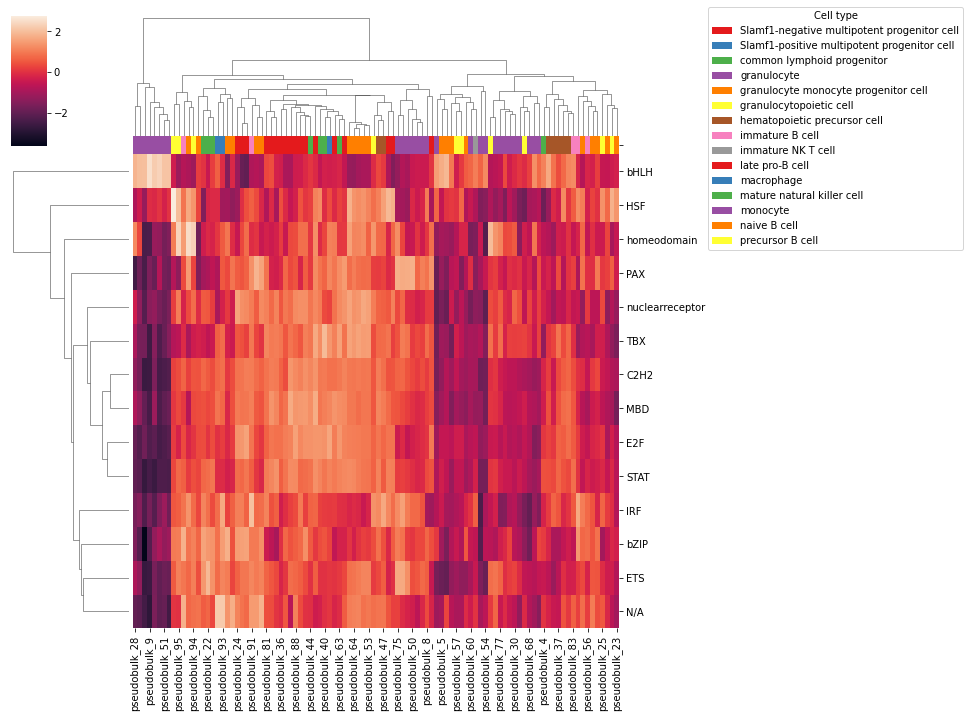

In [68]:
from matplotlib.patches import Patch

network_labels = ad.obs['most_abundant_celltype']
# network_pal = sns.hls_palette(len(set(network_labels)))
# network_pal = sns.color_palette("Set2", len(set(network_labels)))
network_pal = sns.color_palette("Set1", len(set(network_labels)))
network_lut = dict(zip(map(str, sorted(set(network_labels))), network_pal))
network_colors = pd.Series(list(network_labels)).map(network_lut)
network_colors.index = fams_loo_df.columns

sns.clustermap(scov.to_z(fams_loo_df), col_colors=network_colors)

handles = [Patch(facecolor=network_lut[name]) for name in network_lut]
plt.legend(handles, network_lut, title='Cell type',
           bbox_to_anchor=(1.35, 1), 
           bbox_transform=plt.gcf().transFigure, 
           loc='upper right')
plt.show()

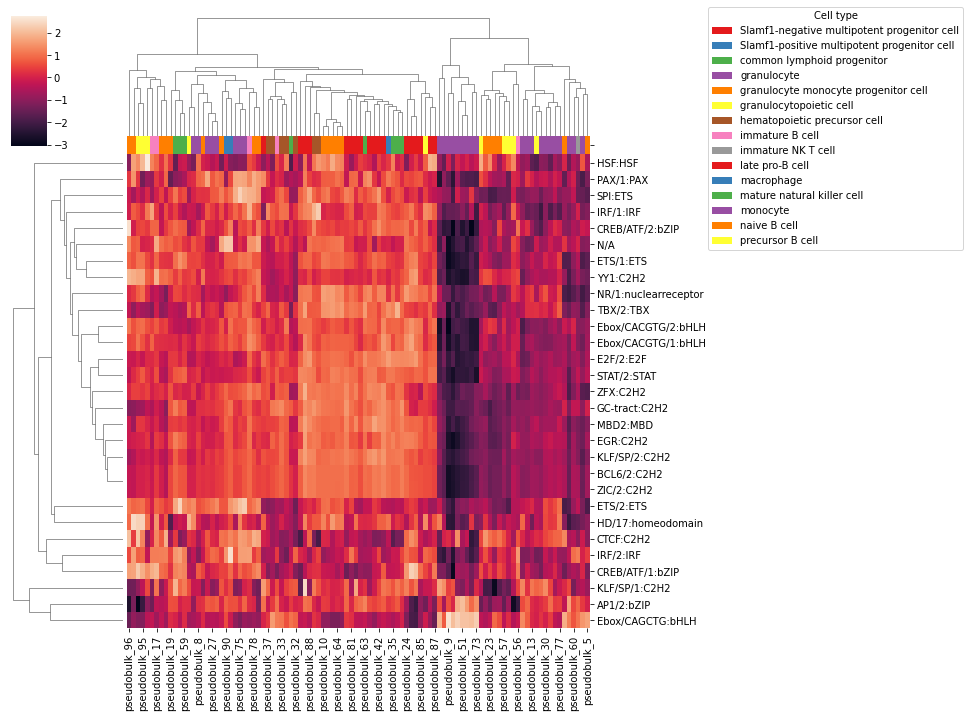

In [116]:
from matplotlib.patches import Patch

network_labels = ad.obs['most_abundant_celltype']
# network_pal = sns.hls_palette(len(set(network_labels)))
# network_pal = sns.color_palette("Set2", len(set(network_labels)))
network_pal = sns.color_palette("Set1", len(set(network_labels)))
network_lut = dict(zip(map(str, sorted(set(network_labels))), network_pal))
network_colors = pd.Series(list(network_labels)).map(network_lut)
network_colors.index = subfams_loo_df.columns

sns.clustermap(scov.to_z(subfams_loo_df), col_colors=network_colors)

handles = [Patch(facecolor=network_lut[name]) for name in network_lut]
plt.legend(handles, network_lut, title='Cell type',
           bbox_to_anchor=(1.35, 1), 
           bbox_transform=plt.gcf().transFigure, 
           loc='upper right')
plt.show()

## Calculate motif family reproducibility

In [69]:
fam_repro = {}
subfam_repro = {}
for fam in motif_families["family"].unique():
    curr_df = motif_families[motif_families["family"] == fam]
    fam_repro[fam] = len(set([x.split("_")[0] for x in curr_df["motif"]])) / k_outer
for subfam in motif_families["subfamily"].unique():
    curr_df = motif_families[motif_families["subfamily"] == subfam]
    subfam_repro[subfam] = len(set([x.split("_")[0] for x in curr_df["motif"]])) / k_outer

In [70]:
motif_families["family_genes"] = [list(jvdf[jvdf["Cluster_name"] == x]["mouse_gene"].unique()) for x in motif_families["subfamily"]]

In [71]:
# Subset to reproducible motif families
motif_families_repro = motif_families[[x in [x for x in subfam_repro if subfam_repro[x] >= 0.5 and x != "N/A"] for x in motif_families['subfamily']]]

## Get correlations to expression levels

In [75]:
expression_hits_df = scov.get_expression_hits_df(ad, 
                                                 all_loo_scores_df,
                                                 motif_families_repro,
                                                 fdr_correct = True,
                                                 gene_symbols = 'symbol', 
                                                 correlation = 'spearman')

In [77]:
expression_hits_df

,family,gene,mean_expression,correlation,pval
0,E2F/2:E2F,E2f1,2.930374,0.574215,6.313779e-10
1,E2F/2:E2F,Tfdp1,3.391339,0.479020,4.616099e-07
2,E2F/2:E2F,E2f4,3.496344,0.856624,1.917684e-29
3,E2F/2:E2F,E2f6,2.701726,0.867653,1.002529e-30
4,E2F/2:E2F,E2f3,2.524188,0.711590,2.123212e-16
...,...,...,...,...,...
9,ETS/2:ETS,Etv4,0.220017,-0.063428,6.368393e-01
10,ETS/2:ETS,Etv6,3.161923,0.223476,6.099948e-02
11,ETS/2:ETS,Ets2,2.924959,-0.058236,6.162926e-01
0,SPI:ETS,Spib,3.011027,0.066588,5.103816e-01


## Test set prediction

In [80]:
from scipy.stats import pearsonr

corrs = []
for curr_outer in tqdm(range(k_outer)):
    curr_test_idx = idx_sets['test'][curr_outer]
    test_data = scov.SeqDataset(X_seqs[curr_test_idx], X_data[curr_test_idx], dtype="float")
    test_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)
    best_config = all_best_configs[curr_outer]
    sn = scov.SeqNet(seq_length=seq_length, 
                     output_size=output_size, 
                     learning_rate=best_config["learning_rate"],
                     motif_length=12,
                     num_motifs=600,
                     sigma_motifs=best_config["sigma_motifs"],
                     sigma_net=best_config["sigma_net"])
    state_dict_path = f"models/{exp_name}_trained_outer_" + str(
        curr_outer) + ".p"
    sn.load_state_dict(torch.load(state_dict_path))
    if torch.cuda.is_available():
        sn = sn.cuda()
    sn = sn.eval()
    
    curr_predictions = np.zeros((len(test_data), output_size))
    curr_ground_truth = np.zeros((len(test_data), output_size))
    curr_start_idx = 0
    for idx, (X,Y) in enumerate(tqdm(test_loader)):
        if torch.cuda.is_available():
            X = X.to(torch.device('cuda'))
        curr_pred = sn(X)
        curr_pred_len = curr_pred.shape[0]
        curr_predictions[curr_start_idx:curr_start_idx+curr_pred_len,:] = curr_pred.detach().cpu().numpy()
        curr_ground_truth[curr_start_idx:curr_start_idx+curr_pred_len,:] = Y.detach().cpu().numpy()
        curr_start_idx += curr_pred_len
    corrs.append(pearsonr(curr_ground_truth.flatten(), curr_predictions.flatten())[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

## Plot example 'fold' correlations

This represents the last fold.

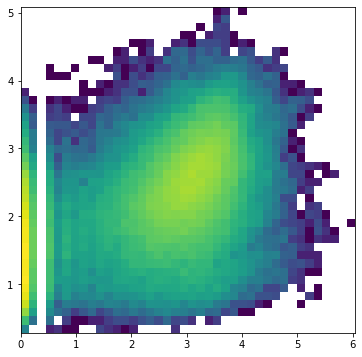

0.4644166976393273


In [83]:
plt.figure(figsize=(6,6))
plt.hist2d(curr_ground_truth.flatten(), curr_predictions.flatten(), 
           norm=mpl.colors.LogNorm(), bins=40);
plt.show()

# Print mean of all correlations:
print(np.mean(corrs))

In [84]:
np.mean(np.array(corrs)*np.array(corrs))

0.2249231600335217

## Example follow-up for correlations

In [92]:
def get_subfam_exp_corr_df(subfam, gene,
                           ad, all_loo_scores_df, motif_families_repro):
    agg_scores = all_loo_scores_df.loc[motif_families[motif_families['subfamily'] == subfam]['motif']] \
                                  .to_numpy().sum(0)
    exp_scores = list(ad[:,gene].X[:,0])
    print("Spearman R = " + str(round(spearmanr(agg_scores,exp_scores)[0], 2)))
    return pd.DataFrame({'agg_scores': agg_scores,
                         'exp_scores': exp_scores,
                         'most_abundant_celltype': ad.obs['most_abundant_celltype'].copy()})

In [93]:
motif_families_repro['subfamily'].unique()

array(['E2F/2:E2F', 'ZFX:C2H2', 'ETS/1:ETS', 'KLF/SP/2:C2H2', 'MBD2:MBD',
       'YY1:C2H2', 'ETS/2:ETS', 'SPI:ETS'], dtype=object)

Spearman R = 0.61


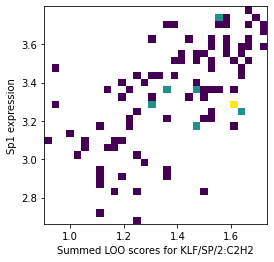

In [110]:
mpl.rcParams["figure.figsize"] = (4,4)
curr_fam = "KLF/SP/2:C2H2"
curr_gene = "Sp1"
w_e_df = get_subfam_exp_corr_df(curr_fam, curr_gene,
                       ad, all_loo_scores_df, motif_families_repro)
plt.hist2d(data=w_e_df, x='agg_scores', y='exp_scores', bins=30,
           norm=mpl.colors.LogNorm());
plt.xlabel("Summed LOO scores for " + curr_fam)
plt.ylabel(curr_gene + " expression");

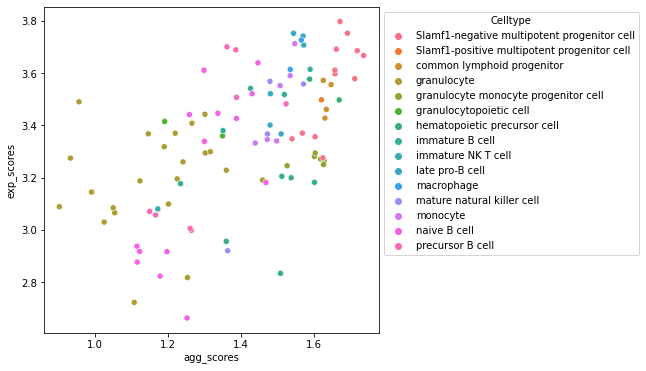

In [112]:
mpl.rcParams["figure.figsize"] = (6,6)
g = sns.scatterplot(data=w_e_df, x='agg_scores', y='exp_scores', hue='most_abundant_celltype')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Celltype')
plt.show()

## Aggregate influence scores

Sometimes it is useful to aggregate the motif scores for the motif families to get a sense of the collective impact of a motif family:

In [118]:
all_pools = []
all_subfam = []
all_bulk_sums = []
all_celltype = []
for subfam in motif_families_repro['subfamily'].unique():
    curr_subdf = all_loo_scores_df.loc[motif_families_repro[motif_families_repro['subfamily'] == subfam]['motif']]
    curr_bulk_sums = curr_subdf.sum(0)
    all_pools += list(curr_bulk_sums.index)
    all_subfam += [subfam for x in range(len(curr_bulk_sums))]
    all_bulk_sums += list(curr_bulk_sums)
    all_celltype += list(ad.obs['most_abundant_celltype'])
all_loo_scores_df_aggregate_melt = pd.DataFrame({'subfamily': all_subfam,
                                                 'sum': all_bulk_sums,
                                                 'celltype': all_celltype},
                                                index=all_pools)

In [127]:
all_loo_scores_df_aggregate_melt

,subfamily,sum,celltype
pseudobulk_0,E2F/2:E2F,0.225475,naive B cell
pseudobulk_1,E2F/2:E2F,0.146070,granulocyte
pseudobulk_2,E2F/2:E2F,0.370010,late pro-B cell
pseudobulk_3,E2F/2:E2F,0.163310,naive B cell
pseudobulk_4,E2F/2:E2F,0.251760,mature natural killer cell
...,...,...,...
pseudobulk_95,SPI:ETS,0.077828,precursor B cell
pseudobulk_96,SPI:ETS,0.081325,naive B cell
pseudobulk_97,SPI:ETS,0.094654,naive B cell
pseudobulk_98,SPI:ETS,0.067890,immature NK T cell


## Save data

In [ ]:
motif_families.to_csv(f"output/{exp_name}_motif_families.csv")
motif_families_repro.to_csv(f"output/{exp_name}_motif_families_repro.csv")
all_loo_scores_df_aggregate_melt.to_csv(f"output/{exp_name}_all_loo_scores_df_aggregate_melt.csv")


## Appendix

In the full Tabula Muris dataset case I would also do an analysis based on the cell type category, but that is slightly counterproductive in this case:

In [114]:
celltype_to_category = {
    "B cell": "immune",
    "Slamf1-negative multipotent progenitor cell": "immune", #
    "Slamf1-positive multipotent progenitor cell": "immune", #
    "T cell": "immune",
    "astrocyte": "macroglial",
    "basal cell": "epithelial",
    "basal cell of epidermis": "epithelial",
    "bladder cell": "connective",
    "bladder urothelial cell": "epithelial",
    "blood cell": "erythrocyte",
    "brain pericyte": "pericyte",
    "Brush cell of epithelium proper of large intestine": "epithelial",
    "cardiac muscle cell": "muscle",
    "classical monocyte": "immune",
    "common lymphoid progenitor": "immune", #
    "endocardial cell": "endothelial",
    "endothelial cell": "endothelial",
    "endothelial cell of hepatic sinusoid": "endothelial",
    "enterocyte of epithelium of large intestine": "epithelial",
    "enteroendocrine cell": "endocrine",
    "epidermal cell": "epithelial",
    "epithelial cell": "epithelial",
    "epithelial cell of large intestine": "epithelial",
    "epithelial cell of lung": "epithelial",
    "epithelial cell of proximal tubule": "epithelial",
    "erythrocyte": "erythrocyte",
    "fibroblast": "connective",
    "granulocyte": "immune",
    "granulocyte monocyte progenitor cell": "immune",
    "granulocytopoietic cell": "immune",
    "hematopoietic precursor cell": "immune", #
    "hepatocyte": "epithelial",
    "immature B cell": "immune",
    "immature T cell": "immune",
    "immature NK T cell": "immune",
    "keratinocyte": "epithelial",
    "keratinocyte stem cell": "epithelial",
    "kidney collecting duct epithelial cell": "epithelial",
    "Kupffer cell": "immune",
    "large intestine goblet cell": "epithelial",
    "late pro-B cell": "immune",
    "leukocyte": "immune",
    "luminal epithelial cell of mammary gland": "epithelial",
    "lung endothelial cell": "endothelial",
    "lymphocyte": "immune",
    "macrophage": "immune",
    "mature natural killer cell": "immune",
    "mesenchymal cell": "connective",
    "mesenchymal stem cell": "connective",
    "mesenchymal stem cell of adipose": "connective",
    "microglial cell": "immune",
    "monocyte": "immune",
    "myeloid cell": "immune",
    "myofibroblast cell": "connective",
    "naive B cell": "immune",
    "natural killer cell": "immune",
    "neuron": "neuronal",
    "oligodendrocyte": "macroglial",
    "oligodendrocyte precursor cell": "macroglial", #
    "pancreatic A cell": "endocrine",
    "pancreatic D cell": "endocrine",
    "pancreatic acinar cell": "exocrine",
    "pancreatic ductal cell": "epithelial",
    "precursor B cell": "immune",
    "pre-natural killer cell": "immune",
    "skeletal muscle satellite cell": "muscle",
    "skeletal muscle satellite stem cell": "muscle", #
    "smooth muscle cell": "muscle",
    "stromal cell": "connective",
    "stem cell of epidermis": "epithelial", #
    "type B pancreatic cell": "endocrine"
}
ad.obs["most_abundant_celltype_category"] = [celltype_to_category[x] for x in ad.obs['most_abundant_celltype']]
ad.obs["cell_type_category"] = [celltype_to_category[x] for x in ad.obs['most_abundant_celltype']]

/tmp/ipykernel_29816/1794239175.py:74: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs["most_abundant_celltype_category"] = [celltype_to_category[x] for x in ad.obs['most_abundant_celltype']]


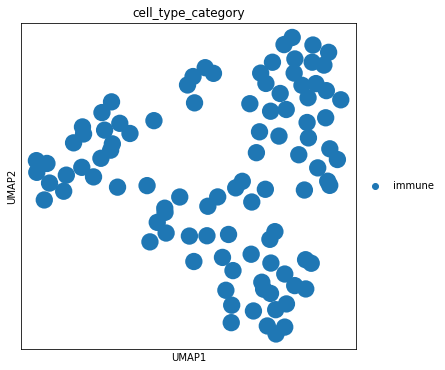

In [115]:
sc.pl.umap(ad, color='cell_type_category')